<a href="https://colab.research.google.com/github/ydsyvn/Spray-Wall-Boulder-Genration/blob/main/final_project_hold_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<h1 dir="rtl">פרוייקט סיום - סגמנטצית אחיזות טיפוס - עידו סיון</h1>



לקחתי את הנתונים מפה:
[github](https://github.com/mcloses/smear-beta)

כתבה שימושית: [Modify Dataset class for COCO data](https://medium.com/fullstackai/how-to-train-an-object-detector-with-your-own-coco-dataset-in-pytorch-319e7090da5)

In [1]:
# Import libraries
import numpy as np
import os
import json
from PIL import Image
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from keras.utils import plot_model

from keras.applications.vgg16 import VGG16

In [3]:
# Mount drive and get dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## <h2 > pytorch </h2>

###<h3> resize the images</h3>

In [4]:
import os
import torch
from PIL import Image
from torchvision.transforms import functional as F
from pycocotools.coco import COCO

class CocoDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, annotation_file, new_size=(640, 480)):
        self.image_dir = image_dir
        self.new_size = new_size
        self.coco = COCO(annotation_file)
        self.ids = list(self.coco.imgs.keys())

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)

        # Load the image
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.image_dir, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")

        # Load the masks
        masks = np.zeros([img_info['height'], img_info['width']])
        for ann in anns:
            mask = coco.annToMask(ann) * 255
            masks = np.maximum(masks, mask)
        masks = Image.fromarray(masks)

        # Resize image and masks
        img = F.resize(img, self.new_size)
        masks = F.resize(masks, self.new_size)

        # Convert to PyTorch tensors
        img = F.to_tensor(img)
        masks = torch.from_numpy(np.array(masks)).long()

        masks = (masks > 0).long()

        return img, masks

    def __len__(self):
        return len(self.ids)


In [5]:
train_dataset = CocoDataset('/content/drive/MyDrive/Data/hold segmentation/segmentation images', '/content/drive/MyDrive/Data/hold segmentation/train.json')


loading annotations into memory...
Done (t=0.89s)
creating index...
index created!


In [6]:
val_dataset = CocoDataset('/content/drive/MyDrive/Data/hold segmentation/segmentation images', '/content/drive/MyDrive/Data/hold segmentation/test.json')


loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


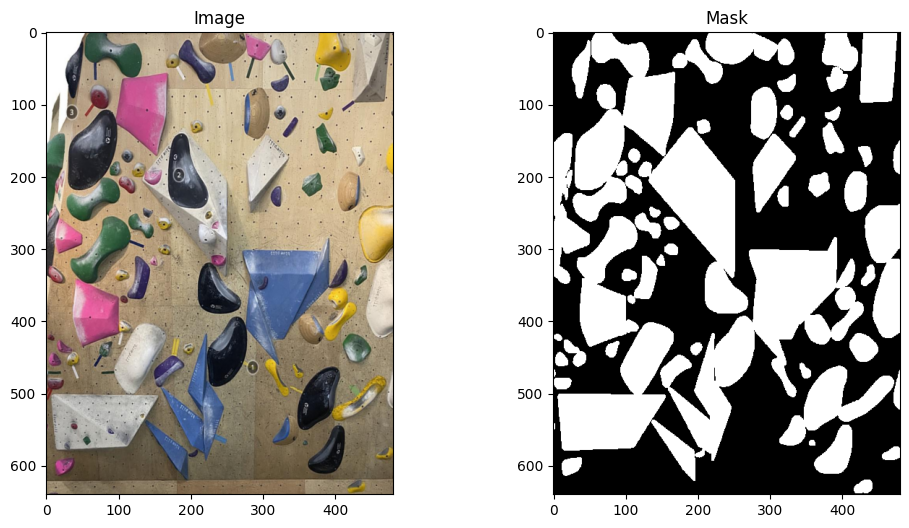

In [7]:
import random

# Select a random image
index = random.randint(0, len(train_dataset) - 1)
img, mask = train_dataset[index]

# Convert tensors to numpy arrays for visualization
img = img.permute(1, 2, 0).numpy()
mask = mask.squeeze().numpy()

# Plot the image and the mask
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(img)
ax[0].set_title('Image')

ax[1].imshow(mask, cmap='gray')
ax[1].set_title('Mask')

plt.show()

In [8]:
from sklearn.metrics import jaccard_score
from torchvision.transforms import functional as F
from sklearn.metrics import accuracy_score

def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    total_accuracy = 0
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_accuracy += accuracy_score(masks.flatten().cpu(), predicted.flatten().cpu())

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_accuracy / len(dataloader)
    return avg_loss, avg_accuracy

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### <h3> transfer learning new </h3>


In [13]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.models.segmentation import fcn_resnet50


In [16]:
import torchvision.models as models

# Load the pre-trained weights
pretrained_weights = fcn_resnet50(pretrained=True).state_dict()

# Create a new model
model = fcn_resnet50(pretrained=False, num_classes=2)

# Load the weights into the new model, excluding the final layer
model_dict = model.state_dict()
pretrained_dict = {k: v for k, v in pretrained_weights.items() if k in model_dict and "classifier" not in k}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 133MB/s]


<All keys matched successfully>

In [19]:
model = model.to(device)

In [17]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [20]:

# Training loop
for epoch in range(10):  # Adjust the number of epochs
    model.train()
    for images, masks in train_loader:
        # Move data to the correct device
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)['out']
        loss = criterion(outputs, masks)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate on the validation set
    val_loss, val_accuracy = evaluate(model, val_loader, device)

    print(f"Epoch {epoch+1}, Training Loss: {loss.item()}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")


Epoch 1, Training Loss: 0.20663607120513916, Validation Loss: 1.571764200925827, Validation Accuracy: 0.8008797200520833
Epoch 2, Training Loss: 0.15527759492397308, Validation Loss: 0.22232595831155777, Validation Accuracy: 0.9161114501953125
Epoch 3, Training Loss: 0.16544510424137115, Validation Loss: 0.3957832232117653, Validation Accuracy: 0.8768297322591145
Epoch 4, Training Loss: 0.11759898066520691, Validation Loss: 0.1670643799006939, Validation Accuracy: 0.9328860473632812
Epoch 5, Training Loss: 0.11368430405855179, Validation Loss: 0.17374644055962563, Validation Accuracy: 0.9326841227213541
Epoch 6, Training Loss: 0.12503518164157867, Validation Loss: 0.1464278493076563, Validation Accuracy: 0.9474138387044271
Epoch 7, Training Loss: 0.05916300043463707, Validation Loss: 0.1284138187766075, Validation Accuracy: 0.9503139241536458
Epoch 8, Training Loss: 0.061481770128011703, Validation Loss: 0.12519111670553684, Validation Accuracy: 0.953978780110677
Epoch 9, Training Loss

In [ ]:
def evaluate(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    total_correct = 0
    total_pixels = 0

    # No need to track gradients in evaluation mode
    with torch.no_grad():
        for images, masks in dataloader:
            # Move data to the correct device
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass and compute the loss
            outputs = model(images)['out']
            loss = criterion(outputs, masks)

            # Compute the number of correct predictions
            predicted = outputs.argmax(1)
            correct = (predicted == masks).sum().item()
            total_correct += correct
            total_pixels += masks.numel()
            total_loss += loss.item()

    # Compute the average loss and accuracy
    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_pixels

    return avg_loss, accuracy


In [ ]:
loss, acc = evaluate(model, )

In [21]:
from PIL import Image
import matplotlib.pyplot as plt

def predict_and_display(model, image_path, device):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image = F.resize(image, (640, 480))  # Adjust the size if necessary
    image = F.to_tensor(image).unsqueeze(0).to(device)

    # Make a prediction
    model.eval()
    with torch.no_grad():
        output = model(image)['out']
    prediction = output.argmax(1).squeeze().cpu().numpy()

    # Load the original image
    original_image = Image.open(image_path)

    # Create a mask image from the prediction
    mask = Image.fromarray(prediction.astype(np.uint8) * 255)

    # Overlay the mask on the original image
    overlay = Image.blend(original_image.convert("RGBA"), mask.convert("RGBA"), alpha=0.5)

    # Display the overlay
    plt.imshow(overlay)
    plt.show()


In [22]:
path_to_image = '/content/drive/MyDrive/Data/hold segmentation/spraywall images/Img_2023_12_10_12_00_59.jpeg'
predict_and_display(model, path_to_image, device)

ValueError: images do not match

In [29]:
import os
import random

def predict_random_image(model, folder_path, device):
    # Select a random image from the folder
    image_path = random.choice(os.listdir(folder_path))
    image_path = os.path.join(folder_path, image_path)

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image = F.resize(image, (640, 480))  # Adjust the size if necessary
    image = F.to_tensor(image).unsqueeze(0).to(device)

    # Make a prediction
    model.eval()
    with torch.no_grad():
        output = model(image)['out']
    prediction = output.argmax(1).squeeze().cpu().numpy()

    # Load the original image
    original_image = Image.open(image_path)

    # Create a mask image from the prediction
    mask = Image.fromarray(prediction.astype(np.uint8) * 255)

    # Display the original image and the mask side by side
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(original_image)
    ax[0].set_title('Original Image')
    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title('Predicted Mask')
    plt.show()


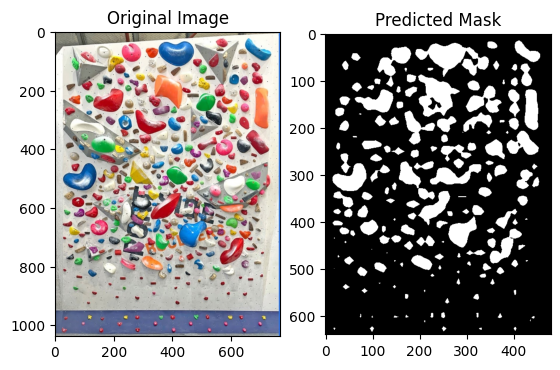

In [33]:
path_to_folder = '/content/drive/MyDrive/Data/hold segmentation/spraywall images/'
predict_random_image(model, path_to_folder, device)

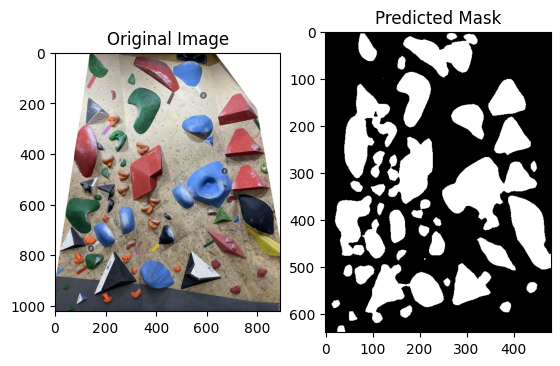

In [37]:
path_to_folder = '/content/drive/MyDrive/Data/hold segmentation/segmentation images'
predict_random_image(model, path_to_folder, device)

###<h3> transfer learning</h3>

#### <h4> define the model</h4>

In [ ]:

# Define the model
model = fcn_resnet50(pretrained=False, num_classes=2)  # Adjust num_classes
model = model.to(device)


In [ ]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [ ]:
# Initialize lists to save the history of train loss and accuracy
train_loss_history = []
train_accuracy_history = []

# Training loop
for epoch in range(10):  # Adjust the number of epochs
    model.train()
    total_loss = 0
    total_accuracy = 0
    for images, masks in train_loader:
        # Move data to the correct device
        images = images.to('cuda')
        masks = masks.to('cuda')

        # Forward pass
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_accuracy += accuracy_score(masks.flatten().cpu(), predicted.flatten().cpu())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate average loss and accuracy
    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_accuracy / len(train_loader)

    # Save the average loss and accuracy in the history lists
    train_loss_history.append(avg_loss)
    train_accuracy_history.append(avg_accuracy)

    print(f"Epoch {epoch+1}, Training Loss: {avg_loss}, Training Accuracy: {avg_accuracy}")


In [ ]:
import matplotlib.pyplot as plt

# Initialize lists to save the history of train and validation loss and accuracy
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

# Training loop
for epoch in range(10):  # Adjust the number of epochs
    model.train()
    total_loss = 0
    total_accuracy = 0
    for images, masks in train_loader:
        # Move data to the correct device
        images = images.to('cuda')
        masks = masks.to('cuda')

        # Forward pass
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_accuracy += accuracy_score(masks.flatten().cpu(), predicted.flatten().cpu())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate average loss and accuracy
    avg_train_loss = total_loss / len(train_loader)
    avg_train_accuracy = total_accuracy / len(train_loader)

    # Evaluate on the validation set
    avg_val_loss, avg_val_accuracy = evaluate(model, val_loader, 'cuda')

    # Save the average loss and accuracy in the history lists
    train_loss_history.append(avg_train_loss)
    train_accuracy_history.append(avg_train_accuracy)
    val_loss_history.append(avg_val_loss)
    val_accuracy_history.append(avg_val_accuracy)

    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss}, Training Accuracy: {avg_train_accuracy}, Validation Loss: {avg_val_loss}, Validation Accuracy: {avg_val_accuracy}")



Epoch 1, Training Loss: 0.8011623833860669, Training Accuracy: 0.3767806047712054, Validation Loss: 0.7719019055366516, Validation Accuracy: 0.34714579264322915
Epoch 2, Training Loss: 0.8002967238426208, Training Accuracy: 0.3768327752976191, Validation Loss: 0.7997901290655136, Validation Accuracy: 0.36039520263671876
Epoch 3, Training Loss: 0.8018364437988826, Training Accuracy: 0.375546636672247, Validation Loss: 0.8012068122625351, Validation Accuracy: 0.3724522908528646
Epoch 4, Training Loss: 0.801350895847593, Training Accuracy: 0.3773478073846726, Validation Loss: 0.7999335825443268, Validation Accuracy: 0.3773267618815104
Epoch 5, Training Loss: 0.8023000359535217, Training Accuracy: 0.3761032482328869, Validation Loss: 0.8003410845994949, Validation Accuracy: 0.37738047281901044


KeyboardInterrupt: 

In [ ]:
# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history, label='Train Accuracy')
plt.plot(val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epochs')

In [ ]:
# Training loop
for epoch in range(10):  # Adjust the number of epochs
    model.train()
    for images, masks in train_loader:
        # Move data to the correct device
        images = images.to('cuda')
        masks = masks.to('cuda')

        # Forward pass
        outputs = model(images)['out']
        loss = criterion(outputs, masks)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate on the validation set
    val_loss, val_accuracy = evaluate(model, val_loader, 'cuda')

    print(f"Epoch {epoch+1}, Training Loss: {loss.item()}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")


Epoch 1, Training Loss: 0.7292770147323608, Validation Loss: 0.7278841137886047, Validation Accuracy: 0.4004034423828125


KeyboardInterrupt: 

In [ ]:
loss, acc = evaluate(model, val_loader, device)

print("Loss: ", loss)
print("accuracy: ", acc)

Loss:  0.14294338412582874
accuracy:  0.9454896036783853


In [ ]:

# Plot the training graph
plt.figure(figsize=(10, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history, label='Training Accuracy', color='orange')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


#### <h4 dir="ltr"> predict </h4>

In [ ]:
def predict_and_show(model, image, device):
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        output = model(image.unsqueeze(0))['out']
        _, predicted = torch.max(output, 1)
        predicted = predicted.squeeze(0).cpu()

    # Convert the tensor image to PIL image
    pil_image = F.to_pil_image(image.cpu())

    # Create a subplot
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Display the original image
    axs[0].imshow(pil_image)
    axs[0].set_title('Original Image')

    # Display the mask
    axs[1].imshow(predicted, cmap='gray')
    axs[1].set_title('Predicted Mask')

    # Remove the x and y ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

    return predicted


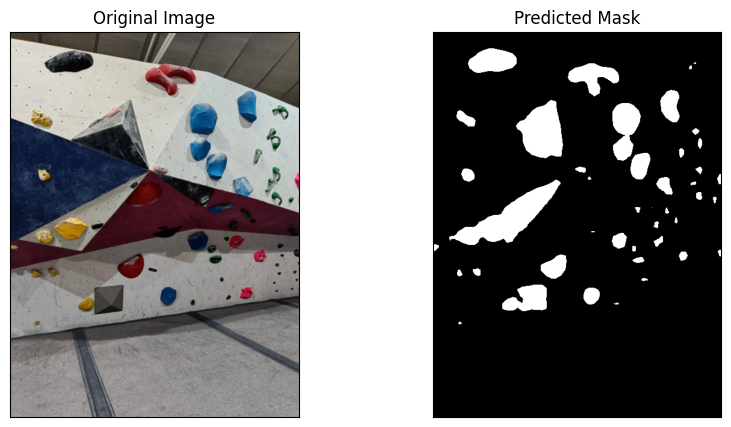

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [ ]:
image, _ = val_dataset[12]
predict_and_show(model, image, 'cuda')

In [ ]:
import numpy as np

def predict_and_show(model, image, device):
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        output = model(image.unsqueeze(0))['out']
        _, predicted = torch.max(output, 1)
        predicted = predicted.squeeze(0).cpu()

    # Convert the tensor image to PIL image
    pil_image = F.to_pil_image(image.cpu())

    # Convert the predicted mask to a PIL image
    pil_mask = F.to_pil_image(predicted)

    # Create an RGB image with the same size as the original image
    overlay = Image.new('RGB', pil_image.size)

    # Paste the original image and the mask into the overlay image
    overlay.paste(pil_image)
    overlay.paste(pil_mask, mask=pil_mask)

    # Display the overlay
    plt.imshow(overlay)
    plt.show()

    return predicted


In [ ]:
image, _ = val_dataset[0]
predict_and_show(model, image, 'cuda')


In [ ]:
from PIL import Image

def predict_image_file(model, image_file, device):
    # Load the image
    img = Image.open(image_file).convert("RGB")

    # Apply the same transformations as you did for your training images
    img = F.resize(img, train_dataset.new_size)
    img = F.to_tensor(img)

    # Use the model to make a prediction
    predicted_mask = predict_and_show(model, img, device)

    return predicted_mask


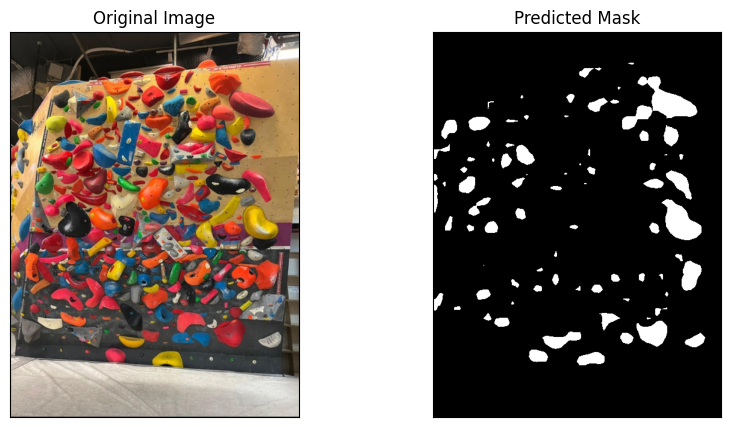

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [ ]:
path = '/content/drive/MyDrive/Data/hold segmentation/spraywall images/Img_2023_12_10_12_09_18.jpeg'
predict_image_file(model, path, 'cuda')

###<h3> CNN model</h3>

#### <h4> try 1</h4>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super(SegNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super(SegNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model = SegNet().to(device)

In [ ]:
from torchvision import models
from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
  ConvTranspose2d-11         [-1, 64, 112, 112]          32,832
             ReLU-12         [-1, 64, 112, 112]               0
  ConvTranspose2d-13         [-1, 32, 224, 224]           8,224
             ReLU-14         [-1, 32, 2

In [ ]:
criterion = nn.BCEWithLogitsLoss()  # nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
def calculate_accuracy(preds, targets):
    preds = preds.argmax(dim=1)
    correct = (preds == targets).float()
    acc = correct.sum() / (targets.size(0) * targets.size(1) * targets.size(2))
    return acc


In [ ]:
num_epochs = 10
history = {'loss': [], 'accuracy': []}  # To store the history of losses and accuracies

for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0

    for inputs, masks in train_loader:
        inputs = inputs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        acc = calculate_accuracy(outputs, masks)

        print(loss.item(), inputs.size(0))

        running_loss += loss.item() * inputs.size(0)
        running_acc += acc.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_acc / len(train_dataset)

    print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    history['loss'].append(epoch_loss)
    history['accuracy'].append(epoch_acc)


-28.542741775512695 4
-39.8118896484375 4
-28.056888580322266 4
-56.91232681274414 4
-46.75266647338867 4
-49.462642669677734 4
-34.832767486572266 4
-22.176279067993164 4
-19.926923751831055 4
-60.09560012817383 4
-53.55847930908203 4
-38.76544189453125 4
-29.35395622253418 4
-35.30968475341797 4
-24.397775650024414 4
-42.14720153808594 4
-28.194570541381836 4
-50.88072204589844 4
-31.449539184570312 4
-32.14875411987305 4
-41.06757736206055 4
-29.885515213012695 4
-43.799591064453125 4
-28.748828887939453 4
-37.71989059448242 4
-29.735239028930664 4
-52.66423416137695 4
-32.341835021972656 1
Epoch 0/9, Loss: -37.5957, Accuracy: 1018465.0367
-54.17123031616211 4
-46.87080001831055 4
-37.71992492675781 4
-21.785797119140625 4
-39.585533142089844 4
-33.703800201416016 4
-55.69613265991211 4
-34.368919372558594 4
-32.833736419677734 4
-41.29693603515625 4
-30.977924346923828 4
-36.30754470825195 4
-32.66445541381836 4
-33.80281448364258 4
-42.892215728759766 4
-66.9519271850586 4
-38.787

In [ ]:
def predict(model, image):
    # Ensure the model is in evaluation mode
    model.eval()

    # Move the image to the device
    image = image.to(device)

    # Add an extra batch dimension
    image = image.unsqueeze(0)

    # Forward pass
    with torch.no_grad():
        output = model(image)

    # Apply sigmoid and remove batch dimension
    output = torch.sigmoid(output).squeeze(0)

    # Move the output back to CPU and convert to numpy array
    output = output.cpu().numpy()

    return output


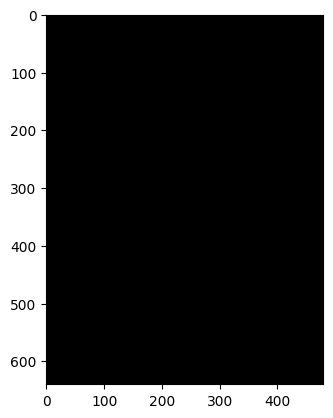

In [ ]:
# Load an image from the dataset
image, _ = train_dataset[0]

# Make a prediction
predicted_mask = predict(model, image)

# Remove the batch dimension for display
predicted_mask = predicted_mask[0]

# Display the predicted mask
plt.imshow(predicted_mask, cmap='gray')
plt.show()

#### <h4> try 2</h4>

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import numpy as np
from torchvision.transforms import functional as F
from pycocotools.coco import COCO
from torch.utils.data import DataLoader


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
def train_model(model, criterion, optimizer, data_loader, num_epochs=25):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(data_loader.dataset)
        epoch_acc = running_corrects.double() / len(data_loader.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    print('Training complete')


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
# Initialize the dataset
train_dataset = CocoDataset('/content/drive/MyDrive/Data/hold segmentation/segmentation images', '/content/drive/MyDrive/Data/hold segmentation/train.json')
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)


loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


In [ ]:
# Initialize the model
model = SimpleCNN()
model = model.to(device)


In [ ]:

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model
train_model(model, criterion, optimizer, train_data_loader, num_epochs=25)


Epoch 0/24
----------


AttributeError: module 'torchvision.transforms.functional' has no attribute 'relu'

## <h2> keras </h2>

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from pycocotools.coco import COCO
import numpy as np
import os

from keras.applications import MobileNetV2
from keras.layers import Conv2D, Reshape
from keras.models import Model

In [ ]:
def CocoGenerator(image_dir, annotation_file, new_size=(640, 480)):
    coco = COCO(annotation_file)
    ids = list(coco.imgs.keys())

    while True:
        for img_id in ids:
            ann_ids = coco.getAnnIds(imgIds=img_id)
            anns = coco.loadAnns(ann_ids)

            # Load the image
            img_info = coco.loadImgs(img_id)[0]
            img_path = os.path.join(image_dir, img_info['file_name'])
            img = load_img(img_path, target_size=new_size)
            img = img_to_array(img)

            # Load the masks
            masks = np.zeros([img_info['height'], img_info['width']])
            for ann in anns:
                mask = coco.annToMask(ann) * 255
                masks = np.maximum(masks, mask)
            masks = np.array(Image.fromarray(masks).resize(new_size))

            masks = (masks > 0).astype('float32')

            yield img, masks


In [ ]:
image_dir = '/content/drive/MyDrive/Data/hold segmentation/segmentation images'
annotation_file = '/content/drive/MyDrive/Data/hold segmentation/test.json'
new_size = (640, 480)

train_gen = CocoGenerator(image_dir, annotation_file, new_size)


In [ ]:
# Load pre-trained MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=[*new_size, 3])

# Add custom layers
x = base_model.output
x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
x = Reshape(new_size)(x)

model = Model(inputs=base_model.input, outputs=x)


9406464/9406464 [==============================] - 1s 0us/step


ValueError: Exception encountered when calling layer "reshape" (type Reshape).

total size of new array must be unchanged, input_shape = [20, 15, 1], output_shape = [640, 480]

Call arguments received by layer "reshape" (type Reshape):
  • inputs=tf.Tensor(shape=(None, 20, 15, 1), dtype=float32)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit_generator(train_gen, steps_per_epoch=100, epochs=10)